<a href="https://colab.research.google.com/github/ialoko/Stroke-Prediction/blob/main/stroke_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q sklearn

In [28]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf
from google.colab import files
files.upload()
clear_output()  # clears console output

#Introduction
According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This model is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status.

# Importing, formatting and cleaning our data

In [9]:
# Importing Data
raw_data = pd.read_csv('healthcare-dataset-stroke-data.csv')
# The id column is not relevant
raw_data.drop(columns=['id'],inplace=True)
# Imputing the missing values with the mean
raw_data= raw_data.fillna(np.mean(raw_data['bmi'])) #to avoid NaN loss later on
dataset = raw_data.copy()
#split dataset insto training dataset and testing dataset
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
y_train = train_dataset.pop('stroke') #pop stroke because that is what we are trying to predict
y_test = test_dataset.pop('stroke') #pop stroke because that is what we are trying to predict

In [10]:
train_dataset.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
42,Male,82.0,0,1,Yes,Private,Urban,144.90,26.4,smokes
380,Male,4.0,0,0,No,children,Rural,106.22,16.7,Unknown
3524,Male,58.0,0,0,Yes,Private,Urban,79.95,25.9,never smoked
352,Female,20.0,0,0,No,Private,Rural,96.57,34.1,never smoked
4927,Female,10.0,0,0,No,children,Rural,69.84,13.7,Unknown


# Let's visualise some helpful data

Text(0.5, 0, '% Stroke')

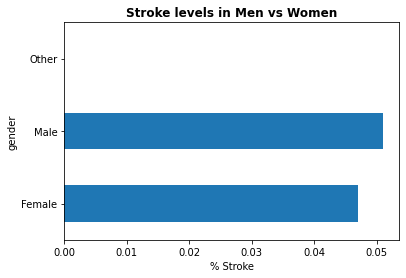

In [11]:
plt.title('Stroke levels in Men vs Women',weight='bold')
dataset.groupby('gender').stroke.mean().plot(kind='barh').set_xlabel('% Stroke')

We can conclude that stroke is more common in men than women.

Text(0.5, 0, '% Stroke')

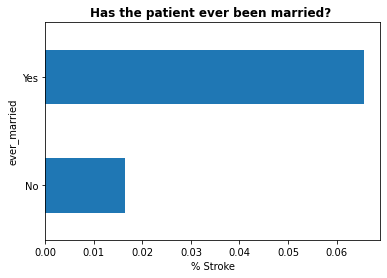

In [12]:
plt.title('Has the patient ever been married? ',weight='bold')
dataset.groupby('ever_married').stroke.mean().plot(kind='barh').set_xlabel('% Stroke')

We can conclude that stroke is significantly higher in those that have been married than those that have never gotten married.

Text(0, 0.5, '% Stroke')

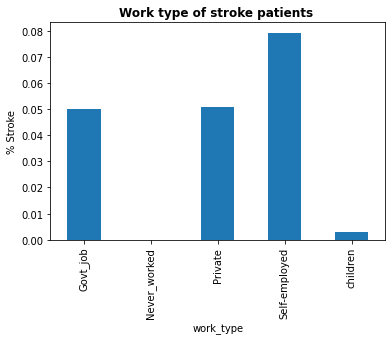

In [13]:
plt.title('Work type of stroke patients ',weight='bold')
dataset.groupby('work_type').stroke.mean().plot(kind='bar').set_ylabel('% Stroke')

We can conclude that stroke is higher amongts those that are self-employed and lowest amongst those that have never worked or are children.

Text(0, 0.5, '% Stroke')

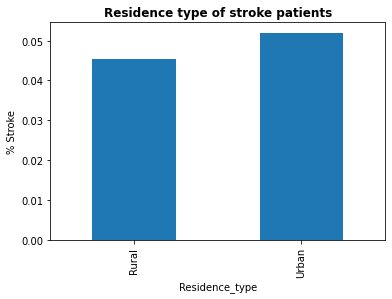

In [14]:
plt.title('Residence type of stroke patients',weight='bold')
dataset.groupby('Residence_type').stroke.mean().plot(kind='bar').set_ylabel('% Stroke')

A higher percentage of stroke patients lived in Urban residences.

stroke
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

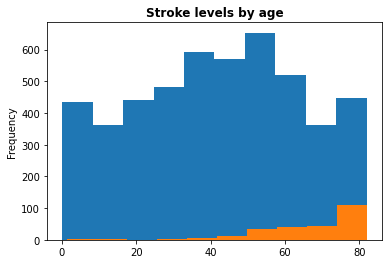

In [15]:
age_stroke = dataset[["age", "stroke"]]
plt.title('Stroke levels by age',weight='bold')
age_stroke.groupby('stroke').age.plot(kind='hist')

Visualizing the age vs stroke levels was difficult to do, as I am still a beginner to the pandas library. However, as shown above, stroke levels increase with age.

Text(0.5, 1.0, 'Comparing the density functions of stroke, hypertension and heart disease')

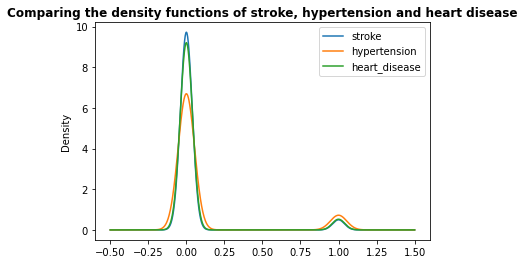

In [16]:
other_health_issues = dataset[["stroke", "hypertension", "heart_disease"]]
df = pd.DataFrame(other_health_issues,columns=["stroke", "hypertension", "heart_disease"])
df.plot(kind = "kde")
plt.title('Comparing the density functions of stroke, hypertension and heart disease',weight='bold')

As shown above, by comparing the probability density functions of the 3 health conditions, we can see an overlap. This is especially true for heart disease and stroke.

Text(0, 0.5, '% Stroke')

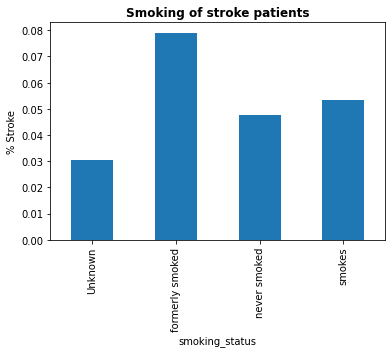

In [17]:
plt.title('Smoking of stroke patients',weight='bold')
dataset.groupby('smoking_status').stroke.mean().plot(kind='bar').set_ylabel('% Stroke')

As seen above, smoking is highest in groups in groups that are former smokers.

Text(0.5, 1.0, 'Analysing bmi levels in stroke patients')

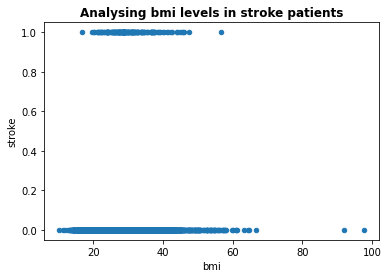

In [18]:
pd.concat([train_dataset, y_train], axis=1).plot(x='bmi', y='stroke', kind = 'scatter')
plt.title('Analysing bmi levels in stroke patients',weight='bold')

Using a scatter plot, we can see that bmi levels in stroke patients on average tend to be higher

# Building a TensorFlow model to predict stroke

In [23]:
# Classifying data into numerical and categorical variables.
NUMERIC_COLUMNS = ['age','avg_glucose_level','bmi']
CATEGORICAL_COLUMNS = ['gender', 'hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type', 
                       'smoking_status']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = train_dataset[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [24]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(train_dataset, y_train)
test_input_fn = make_input_fn(test_dataset, y_test, num_epochs=1, shuffle=False)

In [26]:
# We create a linear estimator by passing the feature columns we created earlier
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(test_input_fn)  # get model metrics/stats by testing on testing data

clear_output()  # clears console output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

0.94520545


Our model has a 94% accuracy rate which is pretty good.

# Predicting probability of stroke in our testing data

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpxut72ixq/model.ckpt-1280
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


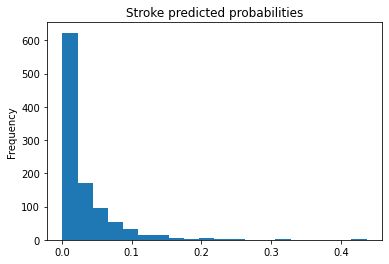

In [27]:
pred_dicts = list(linear_est.predict(test_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='Stroke predicted probabilities')

our testing data has a pretty low probability of stroke.

# Acknowlegements

Used this tutorial to understand the basics of building tensorflow models
https://www.youtube.com/watch?v=tPYj3fFJGjk&t=9962s

Dataset credit to: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset?select=healthcare-dataset-stroke-data.csv

